In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
dataset_path = "dataset"
categories = ["first_print", "second_print"]
# Verify dataset
for c in categories:
    path = os.path.join(dataset_path, c)
    print(f"Category: {c}, Number of images: {len(os.listdir(path))}")



Category: first_print, Number of images: 100
Category: second_print, Number of images: 100


In [ ]:
# Data Preprocessing  
IMG_SIZE = 128  # Resizing images to 128x128  
BATCH_SIZE = 16  # Number of images processed in each batch  

datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to [0,1]  
    rotation_range=15,  # Rotate images slightly to add variation  
    width_shift_range=0.2,  # Shift images horizontally  
    height_shift_range=0.2,  # Shift images vertically  
    zoom_range=0.3,  # Random zoom-in/out for augmentation  
    horizontal_flip=True,  # Flip images to increase diversity  
    brightness_range=[0.8, 1.2],  # Adjust brightness randomly  
    validation_split=0.2  # 20% of data used for validation  
)

# Training & Validation Generators  
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to match input shape  
    color_mode="grayscale",  # Convert images to grayscale  
    batch_size=BATCH_SIZE,  # Process images in small batches  
    class_mode='binary',  # Binary classification (real vs. fake)  
    subset='training'  # Use this part of data for training  
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),  
    color_mode="grayscale",  
    batch_size=BATCH_SIZE,  
    class_mode='binary',  
    subset='validation'  # Use this part of data for validation  
)


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
def build_cnn(input_shape=(128, 128, 1)):
    model = keras.Sequential([
        # First convolutional layer with batch normalization and pooling
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Second convolutional layer with increased filters
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Flatten(),  # Flatten feature maps into a 1D vector

        Dense(64, activation='relu'),  # Fully connected layer with reduced neurons
        Dropout(0.5),  # Dropout to reduce overfitting
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn()
model.summary()


c:\Users\jaysu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,729 (14.14 MB)

 Trainable params: 3,705,537 (14.14 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# class weights added to handel class imbalancce
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train with class weights
history = model.fit(train_generator, validation_data=val_generator, epochs=20, class_weight=class_weights_dict)


c:\Users\jaysu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 590ms/step - accuracy: 0.4885 - loss: 9.5900 - val_accuracy: 0.5000 - val_loss: 2.1390
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 480ms/step - accuracy: 0.6767 - loss: 4.7325 - val_accuracy: 0.5000 - val_loss: 1.0662
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 673ms/step - accuracy: 0.6858 - loss: 2.9127 - val_accuracy: 0.5000 - val_loss: 3.0184
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 731ms/step - accuracy: 0.6579 - loss: 1.1555 - val_accuracy: 0.5000 - val_loss: 3.7390
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 905ms/step - accuracy: 0.6417 - loss: 1.4721 - val_accuracy: 0.5000 - val_loss: 4.8625
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 774ms/step - accuracy: 0.6811 - loss: 0.5761 - val_accuracy: 0.5000 - val_loss: 5.4652
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 835ms/step - accuracy: 0.7318 - loss: 0.5997 - val_accuracy: 0.5000 - val_loss: 5.9878
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 751ms/step - accuracy: 0.6093 - loss: 0.6371 - val_accuracy: 0.

In [ ]:
loss, accuracy = model.evaluate(val_generator)
print(f"\nFinal Validation Accuracy: {accuracy:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.4922 - loss: 15.2699

✅ Final Validation Accuracy: 0.50


In [ ]:
y_pred = (model.predict(val_generator) > 0.5).astype("int32")
y_true = val_generator.classes

print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        20
           1       0.00      0.00      0.00        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40


🔹 Confusion Matrix:
 [[20  0]
 [20  0]]


c:\Users\jaysu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jaysu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jaysu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Original", "Counterfeit"], yticklabels=["Original", "Counterfeit"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


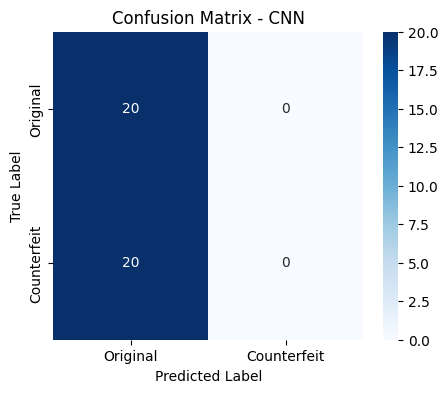

In [10]:
plot_confusion_matrix(y_true, y_pred, "CNN")
